# Siamese Neural Networks (SNN) - Exemplo

## John W. S. de Lima

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
from random import random, randint, seed
import pickle
import pathlib
import warnings
import platform

import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import load_model

In [2]:
print("Python- Versão: ", platform.python_version())
print("TensorFLow - Versão: ",tf.__version__)

# Checar GPUs
if not tf.test.gpu_device_name():
    warnings.warn('GPU não encontrada.')
else:
    print(f'Dispositivo GPU padrão: {tf.test.gpu_device_name()}')
    print("Número de GPUs Disponíveis: ", len(tf.config.list_physical_devices('GPU')))


Python- Versão:  3.8.13
TensorFLow - Versão:  2.9.0
Dispositivo GPU padrão: /device:GPU:0
Número de GPUs Disponíveis:  1


In [3]:
# Essa função faz um preprocessamento inicial e retorna uma array de imagens e um array de labels que seram usadas como entrada 
# na função pares()
def get_images_labels(fileimgpathTrainorTeste):
    # fileimgpathTrainorTeste -> é o caminho para a pasta global das imagens de treino ou imagens de teste
    # Note que dentro da pata de treino ou teste as imagens devem estar guardadas em outras subpastas de acordo com sua classe
    
    # images -> lista de tensores (dados das imagens)
    # labels -> lista de classe para cada uma das imagens (cada classe tem o índice correspondente a imagem na lista images )
    images = [] 
    labels = []
    
    # walkdir -> é uma árvore de diretórios.
    # root, dirs, files respectivamente, diretório raiz, diretórios secundários e arquivos
    walkdir = os.walk(fileimgpathTrainorTeste, topdown=False)
    for root, dirs, files in walkdir:
        if len(dirs) != 0:
            # Obter a todas as classes disponíveis para a pata indicada pelo diretório em fileimgpathTrainorTeste
            classes = dirs           

            
    walkdir = os.walk(fileimgpathTrainorTeste, topdown=False)
    for root, dirs, files in walkdir:
        if len(files) != 0:
            # Para cada imagem obtemos a sua classe e salvamos os seus dados
            for name in files:
                for cl in classes:
                    if root.find(cl)!=-1:
                        # reldir originalmente era ..\Train, mas queremos apenas Train. Retíra-se os três primeiros caracteres
                        reldir = os.path.relpath(fileimgpathTrainorTeste, classes[0])[3:]
                        pathimg = reldir + "/" + cl + "/" + name
                        # Grava os dados numéricos da imagem (tensor)
                        img = cv2.imread(pathimg)
                        img = cv2.resize(img, (64, 64))
                        img = img/255
                        images.append(img)
                        # Salva a classe correspondente
                        # Observação: as classes estão no formado de string. Desse modo, elas foram codificadas numericamente
                        # de acordo com os ídices da lista de classes 
                        cod = classes.index(cl)
                        labels.append(cod)
    
    return np.array(images), np.array(labels)

In [4]:
# Essa função cria pares de imagens e labels correspondentes para serem usadas na rede siamesa
def pares(images, labels):
    # pairImages -> é uma lista de pares de imagens (image, image)
    # pairLabels -> é uma lista de labels (binário) indicando que o par é semelhante(positivo) ou diferente(negativo)
    pairImages = []
    pairLabels = []
    
    # Obtém o número total de classes presentes no conjunto de dados
    numClasses = len(np.unique(labels))
    # Cria uma lista de índices para cada rótulo de classe
    # Vale lembrar que os índices de images e labels se correspondem
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    
    for idxA in range(len(images)):
        # currentImage -> imagem de referência (atual). A partir dela será criado pares positivos e negativos
        # label -> rótulo de referência (atual)
        currentImage = images[idxA]
        label = labels[idxA]
        # Escolhe aleatoriamente uma imagem que pertença ao mesmo rótulo de referência
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        # Cria um par positivo e atualiza as listas de imagens e rótulos
        pairImages.append([currentImage, posImage])
        # Observação: 1 -> label que indica par positivo; 0 -> label que indica par negativo
        pairLabels.append(1)
        # Pega os índices para cada um dos rótulos diferente do rótulo atual 
        # e escolhe aleatoriamente uma imagem correspondente a um rótulo diferente do rótulo atual
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        # Cria um par negativo e atualiza as listas de imagens e rótulos
        pairImages.append([currentImage, negImage])
        pairLabels.append(0)
    # Retorna uma 2-tupla de imagens e rótulos correspondentes
    return np.array(pairImages), np.array(pairLabels)

In [5]:
# Função global que retorna um conjunto de pares de imagens e labels correspondentes para serem usadas em uma rede siamesa
# Observação: ela pega todas as imagens e salva na memória RAM
# Note que One-Shot Learning normalmente precisa de poucos dados para serem treinados
def siamese_datasets(fileimgpathTrainorTeste):
    # fileimgpathTrainorTeste -> é o caminho para a pasta global das imagens de treino ou imagens de teste
    # Note que dentro da pata de treino ou teste as imagens devem estar guardadas em outras subpastas de acordo com sua classe
    
    # Cria arrays de imagens e labels
    X, Y = get_images_labels(fileimgpathTrainorTeste)
    
    # Note que o conjunto de imagens é formado por pares de imagens (2-tupla)
    # Note que os labels são binários o ou 1 -> positivo ou negativo
    pairimgX, pairlabelY = pares(X, Y)
    
    return pairimgX, pairlabelY

In [6]:
# Função constrói cada uma das redes siamesas
def siamese_model(inputShape, embeddingDim):
    # inputShape -> dimensão da entrada da rede
    # embeddingDim -> dimensão de saída da camada densa
    inputs = Input(inputShape)
    
    # Note que há 3 camadas de convolução e uma camada densa
    # Note também que foi usado a GlobalAveragePooling ao invés de Flatten   
    x = Conv2D(32, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)
    
    model = Model(inputs, outputs)

    return model

In [7]:
# Especificações para o treinamento da rede
# Dimensões do tensor de entrada (imagem)
IMG_SHAPE = (64, 64, 3)
# especificar o BATCH_SIZE, número de EPOCHS e a dimensão de saída camada densa(antes do cálculo da distância euclidiana)
BATCH_SIZE = 32
EPOCHS = 100
DENSE = 32

In [8]:
print("Modelo proposto para cada uma das siamesas: \n")
print(siamese_model(IMG_SHAPE, DENSE).summary())

Modelo proposto para cada uma das siamesas: 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)           

In [9]:
# Obtém os dois tensores e retorna a distância euclidiana entre eles
# Note que vect é uma 2-tupla
# Cada um dos tensores é a saída de cada uma das redes siamesas
def euclidean_distance(vect):
    (featsA, featsB) = vect
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,keepdims=True)
           # k.maximum é uma operação do tipo "Element-wise" e obtém o valor máximo
           # Note que está sendo comparado com K.epsilon() => 1e-07
           # O valor mínimo permitido aqui é 1e-07
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [10]:
# Configura a siamese network
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = siamese_model(IMG_SHAPE, DENSE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# Constrói a siamese network
# Note que se calcula a distância entre os tensores de ssíadas das redes siamesas (camada lambda)
# Depois vem a última camada densa de classificação binária 
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [11]:
# Obtendo conjunto de treino e teste
# Note que o conjunto de imagens é formado por pares de imagens (2-tupla)
# Note que os labels são binários o ou 1 -> positivo ou negativo
pairTrain, labelTrain = siamese_datasets('C:/Users/jwsl/Residência Visão Computacional/Disciplinas/VC2/Lista1/Train')
pairTest, labelTest = siamese_datasets('C:/Users/jwsl/Residência Visão Computacional/Disciplinas/VC2/Lista1/Test')

In [12]:
# Compila e treina o modelo
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Observação: aqui poderia se usar o conjunto de teste como o conjunto de validação ou se criar um conjunto de validação
# a partir do conjunto de treino.
# Desse modo, foi escolhido que 30% do conjunto de treino pertenceria ao conjunto de validação.
# Ao final será usado o conjunto de teste para a avaliação.

'''
history = model.fit([pairTrain[:,0,:,:,:], pairTrain[:,1,:,:,:]], labelTrain,
                    validation_data=([pairTest[:,0,:,:,:], pairTest[:,1,:,:,:]], labelTest[:]),
                    batch_size=BATCH_SIZE, epochs=EPOCHS)
'''

history = model.fit([pairTrain[:,0,:,:,:], pairTrain[:,1,:,:,:]], labelTrain,
                    validation_split=0.3,
                    batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/100
171/171 [==============================] - 16s 52ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6912 - val_accuracy: 0.5357
Epoch 2/100
171/171 [==============================] - 3s 15ms/step - loss: 0.6894 - accuracy: 0.5357 - val_loss: 0.6896 - val_accuracy: 0.5293
Epoch 3/100
171/171 [==============================] - 3s 15ms/step - loss: 0.6857 - accuracy: 0.5458 - val_loss: 0.6886 - val_accuracy: 0.5396
Epoch 4/100
171/171 [==============================] - 3s 15ms/step - loss: 0.6808 - accuracy: 0.5452 - val_loss: 0.6898 - val_accuracy: 0.5212
Epoch 5/100
171/171 [==============================] - 3s 15ms/step - loss: 0.6777 - accuracy: 0.5557 - val_loss: 0.6883 - val_accuracy: 0.5456
Epoch 6/100
171/171 [==============================] - 3s 15ms/step - loss: 0.6735 - accuracy: 0.5659 - val_loss: 0.6930 - val_accuracy: 0.5190
Epoch 7/100
171/171 [==============================] - 3s 15ms/step - loss: 0.6716 - accuracy: 0.5712 - val_loss: 0.6855 - val_accuracy

In [13]:
# Função que constrói um gráfico com o histórico do treinamento
def plot_training(H, plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

INFO:tensorflow:Assets written to: model_save\assets


INFO:tensorflow:Assets written to: model_save\assets


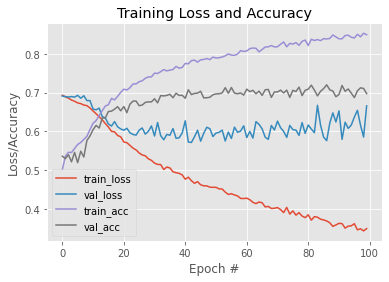

In [14]:
# Salva o modelo e constrói o gráfico

# Salva o modelo completo com pesos, arquiteturas e etc
model.save("model_save")
# Salva os pesos do modelo
model.save_weights("ModelWeights_save/model_weights.h5")
plot_training(history, "plot.png")

### Avaliação do modelo a partir dos pesos salvos e do conjunto de teste

#### Observação: atualmente o método "tf.keras.models.load_model()", usado para carregar o modelo completo, não suporta modelos que contenha camadas lambdas. Desse modo, será usado o carremento dos pesos e a recriação da arquitetura.


In [15]:
# Configura a siamese network
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = siamese_model(IMG_SHAPE, DENSE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# Constrói a siamese network
# Note que se calcula a distância entre os tensores de ssíadas das redes siamesas
# Depois vem a última camada densa de classificação binária 
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
modelload = Model(inputs=[imgA, imgB], outputs=outputs)

In [16]:
# Carregando os pesos do modelo
modelload.load_weights("ModelWeights_save/model_weights.h5")

In [18]:
# Avaliação usando os dados de testes
model.evaluate([pairTest[:,0,:,:,:], pairTest[:,1,:,:,:]], labelTest)


101/101 [==============================] - 1s 6ms/step - loss: 0.7925 - accuracy: 0.5961


[0.7925367951393127, 0.596069872379303]